In [1]:
# pip install -U pyswarms
# pip install -U pymoo

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pyswarms as ps

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.problems.functional import FunctionalProblem
from pymoo.optimize import minimize

In [3]:
# Modela a solução
class Individuo:
    def __init__(self, X, fit):
        self.fit = fit
        self.X = X
    # Atualiza
    def set_fit(self, f_value):
        self.fit = f_value
    def set_position(self, X):
        self.X = X
    # Acessa
    def get_fit(self):
        return self.fit
    def get_position(self):
        return self.X
    # Imprime
    def show(self):
        print('X:', self.X)
        print('Fitness:', self.fit)

class Resultado:
    def __init__(self):
        self.X = None # Solução do problema
        self.fit = None # Best fitness
        self.n_eval = 0 # Número de avaliação de função
        self.n_it = None # Número de iterações

        self.Xs = [] # Melhores indivíduos de cada geração (incluindo a geração inicial)
        self.P = None # População final
    def show(self):
        print('Best Solution:', self.X)
        print('Best Solution Fitness:', self.fit)
        print('Function Evaluation Number:', self.n_eval)
        print('Number of iterations:', self.n_it)

### Entradas:

In [37]:
# Função objetivo:
def f(X, a=1, b=100):
    #x, y = X
    #return (a - x)**2 + b*(y - x**2)**2 # Rosenbrock
    S = 0
    for i in range(1, 30):
        S += (a - X[i-1])**2 + b*(X[i] - X[i-1]**2)**2
    return S

def f_ps(X, a=1, b=100):
    #return (a - X[:, 0])**2 + b*(X[:, 1] - X[:, 0]**2)**2 Rosenbrock
    S = 0
    for i in range(1, 30):
        S += (a - X[:, i-1])**2 + b*(X[:, i] - X[:, i-1]**2)**2
    return S

w = 0.5 # Parâmetro de inércia [0, 2]
c1 = 0.2 # Parâmetro cognitivo [0, 1]
c2 = 0.8 # Parâmetro social [0, 1]

NP = 100
dim = 30#2
lims = [(-2.048, 2.048) for i in range(30)] #[(-2.048, 2.048), (-2.048, 2.048)] # Limites inferior e superior de cada componente
num_it = 200 # Número de iterações
inic_it = 0 # Iteração inicial (no gráfico da curva de convergência)
num_exec = 30 # Número de execuções

### Algoritmo:

In [38]:
############## Argumentos ##############
# f -> Função objetivo
# lims -> Lista de duplas contendo o limite mínimo e máximo para cada variável
# w -> Parâmetro de inércia
# c1 Parâmetro cognitivo
# c2 -> Parâmetro social
# NP -> Tamanho da população
# num_it -> Número de iterações
########################################
def pso(f, lims, w, c1, c2, NP=20, num_it=1000):
    # Estrutura de dados para o resultado
    result = Resultado()
    result.n_it = num_it

    dimensions = len(lims) # Calcula a dimensão do problema
    P_norm = np.random.rand(NP, dimensions) # Gera população inicial aleatória em [0, 1]
    min_b, max_b = np.asarray(lims).T # Vetores de mínimo e máximo para limitar
    diff = np.fabs(min_b - max_b) # Tamanho do intervalo
    P = min_b + P_norm * diff # População desnormalizada (para os intervalos corretos)
    V = np.zeros((NP, dimensions)) # Velocidade inicial

    best_P = P # Armazena o melhor indivíduo de cada partícula
    best_fitness = np.asarray([f(ind) for ind in P]) # Gera array com as melhores avaliações da população
    gbest_X_idx = np.argmin(best_fitness) # Índice do melhor vetor inicial
    gbest_X = P[gbest_X_idx] # Melhor vetor inicial
    gbest_fit = best_fitness[gbest_X_idx] # Melhor fitness inicial

    # Armazenando o resultado
    result.X = gbest_X
    result.fit = gbest_fit
    result.n_eval += NP
    result.Xs.append(Individuo(gbest_X, gbest_fit))
    result.P = P

    for i in range(num_it): # Para cada iteração
        for j in range(NP): # Para cada partícula
            r1, r2 = np.random.uniform(0, 1), np.random.uniform(0, 1) # Gera dois números aleatórios
            # Equação do movimento (Limitando a posição e a velocidade)
            V[j] = np.clip(w*V[j] + c1*r1*(best_P[j] - P[j]) + c2*r2*(gbest_X - P[j]), -diff, diff)
            Xj = np.clip(P[j] + V[j], min_b, max_b)
            fj = f(Xj)

            # Verifica se precisa atualizar informações
            if(fj < best_fitness[j]):
                best_P[j] = Xj
                best_fitness[j] = fj
                if(fj < gbest_fit):
                    gbest_X = Xj
                    gbest_fit = fj

            P[j] = Xj
            result.X = gbest_X
        # Atualiza o resultado
        result.fit = gbest_fit
        result.n_eval += NP
        result.Xs.append(Individuo(gbest_X, gbest_fit))
    result.P = P
    return result

In [39]:
alg = pso(f, lims, w, c1, c2, NP, num_it)

alg.show()

Best Solution: [ 0.21569962  0.0698455  -0.1655817   0.12547761  0.09102301  0.01228404
 -0.01370206 -0.0644124  -0.04015227 -0.1433005   0.00821881  0.07651776
  0.14803111  0.05197366 -0.04346743  0.0391095  -0.0867822  -0.00679338
  0.02924414 -0.1623192  -0.12288268  0.14063025 -0.0266241   0.05315328
  0.05396939 -0.15751638 -0.02446223 -0.06262278 -0.0939022   0.15192576]
Best Solution Fitness: 54.08621273093093
Function Evaluation Number: 20100
Number of iterations: 200


### Curva de Convergência

In [40]:
exec_my_pso = []
exec_pymoo_pso = []
exec_pyswarm_pso = []

xl, xu = np.asarray(lims).T
problem = FunctionalProblem(dim, [f], xl=xl, xu=xu)

options = {'c1': c1, 'c2': c2, 'w': w}

for e in range(num_exec):
    # Meu PSO
    exec_my_pso.append(pso(f, lims, w, c1, c2, NP, num_it).Xs)

    # PSO da Pymoo
    algorithm = PSO(pop_size=NP, w=w, c1=c1, c2=c2)
    algorithm.setup(problem, termination=('n_gen', num_it), verbose=False)
    list_pymoo_it = []
    while algorithm.has_next():
        algorithm.next()
        res = algorithm.result()
        list_pymoo_it.append(Individuo(res.X, res.F[0]))
    exec_pymoo_pso.append(list_pymoo_it)

    # PSO da Pyswarms
    optimizer = ps.single.GlobalBestPSO(n_particles=NP, dimensions=dim, options=options, bounds=(xl, xu))
    optimizer.optimize(f_ps, iters=num_it, verbose=False)
    exec_pyswarm_pso.append(optimizer.cost_history) # pos_history para posição

In [41]:
plt_my_pso = []
plt_pymoo_pso = []
plt_pyswarm_pso = []
for it in range(inic_it, num_it):
    media_my_pso = 0
    media_pymoo_pso = 0
    media_pyswarm_pso = 0
    for e in range(num_exec):
        media_my_pso += exec_my_pso[e][it+1].get_fit()
        media_pymoo_pso += exec_pymoo_pso[e][it].get_fit()
        media_pyswarm_pso += exec_pyswarm_pso[e][it]
    plt_my_pso.append(media_my_pso/num_exec)
    plt_pymoo_pso.append(media_pymoo_pso/num_exec)
    plt_pyswarm_pso.append(media_pyswarm_pso/num_exec)

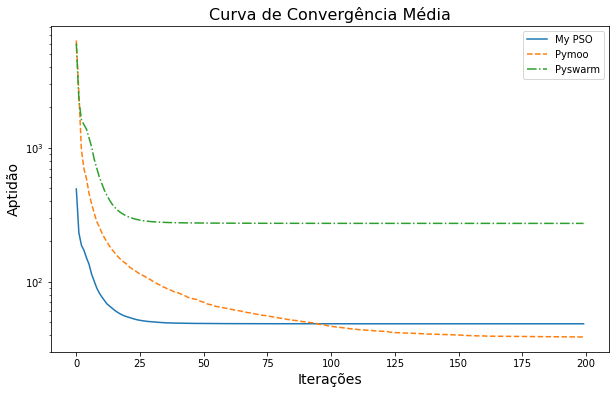

In [42]:
plt.figure(figsize=(10, 6))

plt.plot(range(inic_it, num_it), plt_my_pso, linestyle="-", label="My PSO")
plt.plot(range(inic_it, num_it), plt_pymoo_pso, linestyle="--", label="Pymoo")
plt.plot(range(inic_it, num_it), plt_pyswarm_pso, linestyle="-.", label="Pyswarm")

plt.yscale("log")
plt.title("Curva de Convergência Média", fontsize=16)
plt.legend()
plt.xlabel("Iterações", fontsize=14)
plt.ylabel("Aptidão", fontsize=14)

plt.show()

In [43]:
box_my_pso = []
box_pymoo_pso = []
box_pyswarm_pso = []
for e in range(num_exec):
    box_my_pso.append(exec_my_pso[e][-1].get_fit())
    box_pymoo_pso.append(exec_pymoo_pso[e][-1].get_fit())
    box_pyswarm_pso.append(exec_pyswarm_pso[e][-1])

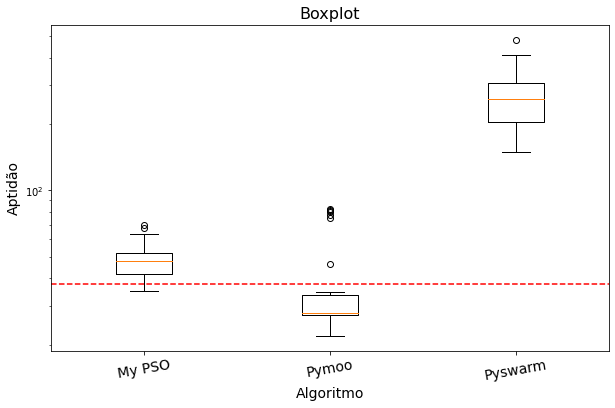

In [45]:
plt.figure(figsize=(10, 6))

plt.boxplot([box_my_pso, box_pymoo_pso, box_pyswarm_pso])

plt.yscale('log')
plt.xticks([1, 2, 3], ['My PSO', 'Pymoo', 'Pyswarm'], rotation=10, fontsize=14)
plt.xlabel("Algoritmo", fontsize=14)
plt.ylabel("Aptidão", fontsize=14)

plt.title("Boxplot", fontsize=16)

def confidence_interval(data):
    # Primeiro e terceiro quartis
    Q1, Q3 = np.percentile(data, [25, 75])
    # Calcular a mediana
    median = np.median(data)
    return Q1, Q3

ci1 = confidence_interval(box_my_pso)
ci2 = confidence_interval(box_pymoo_pso)

# Trace a linha horizontal
overlap = max(ci1[0], ci2[0]), min(ci1[1], ci2[1])
plt.axhline(y=np.mean(overlap), color='r', linestyle='--')

### Problema do Circuito Elétrico

In [10]:
dim = 1
lims = [(-5, 5)]
xl, xu = np.asarray(lims).T

def f(I):
    # parâmetros fixos
    U = 10
    R = 100
    I_s = 9.4e-12
    v_t = 25.85e-3

    # cálculo do custo
    c = abs(U - v_t * np.log(abs(I[0] / I_s)) - R * I[0])
    return c
def f_ps(I):
    # parâmetros fixos
    U = 10
    R = 100
    I_s = 9.4e-12
    v_t = 25.85e-3

    # cálculo do custo
    c = abs(U - v_t * np.log(abs(I[:, 0] / I_s)) - R * I[:, 0])
    return c

In [11]:
exec_my_pso = []
exec_pymoo_pso = []
exec_pyswarm_pso = []

problem = FunctionalProblem(dim, [f], xl=xl, xu=xu)

options = {'c1': c1, 'c2': c2, 'w': w}

for e in range(num_exec):
    # Meu PSO
    exec_my_pso.append(pso(f, lims, w, c1, c2, NP, num_it).Xs)

    # PSO da Pymoo
    algorithm = PSO(pop_size=NP, w=w, c1=c1, c2=c2)
    algorithm.setup(problem, termination=('n_gen', num_it), verbose=False)
    list_pymoo_it = []
    while algorithm.has_next():
        algorithm.next()
        res = algorithm.result()
        list_pymoo_it.append(Individuo(res.X, res.F[0]))
    exec_pymoo_pso.append(list_pymoo_it)

    # PSO da Pyswarms
    optimizer = ps.single.GlobalBestPSO(n_particles=NP, dimensions=dim, options=options, bounds=(xl, xu))
    optimizer.optimize(f_ps, iters=num_it, verbose=False)
    exec_pyswarm_pso.append(optimizer.cost_history) # pos_history para posição

In [12]:
plt_my_pso = []
plt_pymoo_pso = []
plt_pyswarm_pso = []
for it in range(inic_it, num_it):
    media_my_pso = 0
    media_pymoo_pso = 0
    media_pyswarm_pso = 0
    for e in range(num_exec):
        media_my_pso += exec_my_pso[e][it+1].get_fit()
        media_pymoo_pso += exec_pymoo_pso[e][it].get_fit()
        media_pyswarm_pso += exec_pyswarm_pso[e][it]
    plt_my_pso.append(media_my_pso/num_exec)
    plt_pymoo_pso.append(media_pymoo_pso/num_exec)
    plt_pyswarm_pso.append(media_pyswarm_pso/num_exec)

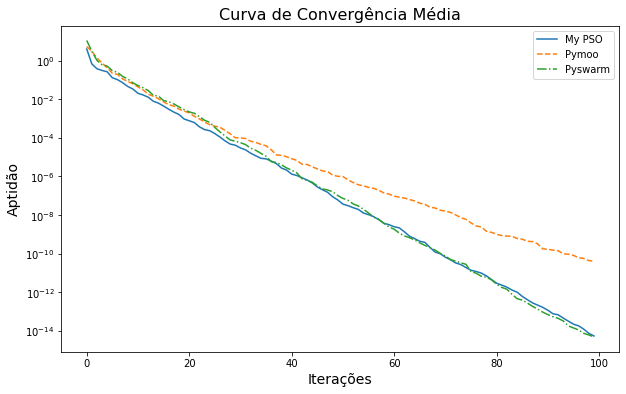

In [13]:
plt.figure(figsize=(10, 6))

plt.plot(range(inic_it, num_it), plt_my_pso, linestyle="-", label="My PSO")
plt.plot(range(inic_it, num_it), plt_pymoo_pso, linestyle="--", label="Pymoo")
plt.plot(range(inic_it, num_it), plt_pyswarm_pso, linestyle="-.", label="Pyswarm")

plt.yscale("log")
plt.title("Curva de Convergência Média", fontsize=16)
plt.legend()
plt.xlabel("Iterações", fontsize=14)
plt.ylabel("Aptidão", fontsize=14)

plt.show()

### Gráfico de Caixa (Boxplot)

In [14]:
box_my_pso = []
box_pymoo_pso = []
box_pyswarm_pso = []
for e in range(num_exec):
    box_my_pso.append(exec_my_pso[e][-1].get_fit())
    box_pymoo_pso.append(exec_pymoo_pso[e][-1].get_fit())
    box_pyswarm_pso.append(exec_pyswarm_pso[e][-1])

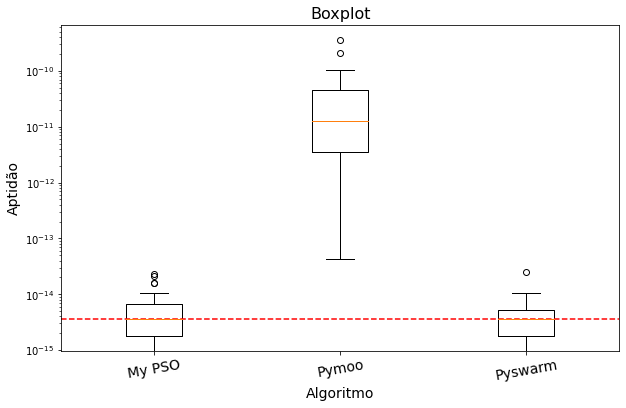

In [15]:
plt.figure(figsize=(10, 6))

plt.boxplot([box_my_pso, box_pymoo_pso, box_pyswarm_pso])

plt.yscale('log')
plt.xticks([1, 2, 3], ['My PSO', 'Pymoo', 'Pyswarm'], rotation=10, fontsize=14)
plt.xlabel("Algoritmo", fontsize=14)
plt.ylabel("Aptidão", fontsize=14)

plt.title("Boxplot", fontsize=16)

def confidence_interval(data):
    # Primeiro e terceiro quartis
    Q1, Q3 = np.percentile(data, [25, 75])
    # Calcular a mediana
    median = np.median(data)
    return Q1, Q3

ci1 = confidence_interval(box_my_pso)
ci2 = confidence_interval(box_pyswarm_pso)

# Trace a linha horizontal
overlap = max(ci1[0], ci2[0]), min(ci1[1], ci2[1])
plt.axhline(y=np.mean(overlap), color='r', linestyle='--')